In [1]:
# import libraries
# Always run this cell first!
import numpy as np
import pandas as pd
import math

import scipy
import statsmodels.api # appear to need to import the api as well as the library itself for the interpreter to find the modules
import statsmodels as sm

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
import plotly.offline
plotly.offline.init_notebook_mode(connected=True) # make plotly work with Jupyter Notebook using CDN

# an extra function for plotting a straight line
def plot_abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

# Linear Regression

We next turn to explore another type of statistical decision making tool, linear regression. Linear regression is a tool to allow us to explore the connections between 2 or more variables. 

### World Bank Development Indicators

The World Development Indicators dataset, maintained by the World Bank, contains information about a wide variety of topics related to global development. The [most recent version](https://datacatalog.worldbank.org/search/dataset/0037712) of the dataset, as of writing, provides over 1500 indicators for 217 economies from 1960 to 2021. The dataset is licensed under a [Creative Commons Attribution 4.0 International License](	https://datacatalog.worldbank.org/public-licenses#cc-by).

For our example, we will look at three statistics related to literacy. We will limit our analysis to the 89 countries that have valid data for all three statistics for at least one year in the time range 2017-2021. For each country, we will consider the most recent year from that time range for which all three statistics are available.

Let's take a look at this data, which is in a file called `world_bank_literacy.csv`.

In [2]:
wbl = pd.read_csv('world_bank_literacy.csv', index_col = 'country_code')
wbl.head()

,country,year,adult_literacy_rate_(pct),primary_school_completion_rate_(pct),primary_school_enrollment_rate_(pct)
country_code,,,,,
ALB,Albania,2021,98.449997,98.155830,95.921783
ARE,United Arab Emirates,2019,95.526482,111.938820,114.412361
ARG,Argentina,2018,99.003868,98.706253,109.659172
ARM,Armenia,2020,99.788612,93.165291,91.235443
AZE,Azerbaijan,2019,99.795982,100.383339,97.935349


The column labeled `adult_literacy_rate_(pct)` (World Bank indicator [SE.ADT.LITR.ZS](https://data.worldbank.org/indicator/SE.ADT.LITR.ZS)) contains the percentage of people age 15 and up in each country who are literate. The World Bank [defines](https://databank.worldbank.org/metadataglossary/world-development-indicators/series/SE.ADT.LITR.ZS) a person as literate if they can "read and write with understanding a short simple statement about their everyday life."

The column labeled `primary_school_enrollment_rate_(pct)` (World Bank indicator [SE.PRM.ENRR](https://data.worldbank.org/indicator/SE.PRM.ENRR)) contains the gross percentage of people enrolled in primary school in each country. This percentage is [calculated](https://databank.worldbank.org/metadataglossary/world-development-indicators/series/SE.PRM.ENRR) by taking the total number of primary school students in a given country (no matter what their age is) and dividing it by the total number of people in the *official* age group for primary school in that country. Because some of the students in primary school might be older or younger than the official primary school ages, this percentage can be greater than 100%.

The column labeled `primary_school_completion_rate_(pct)` (World Bank indicator [SE.PRM.CMPT.ZS](https://data.worldbank.org/indicator/SE.PRM.CMPT.ZS)) contains the gross percentage of people enrolled in the *last* grade of primary school in each country. This percentage is [calculated](https://databank.worldbank.org/metadataglossary/world-development-indicators/series/SE.PRM.CMPT.ZS) by taking the total number of non-repeating students in the last grade of primary school in a given country (no matter what their age is) and dividing it by the total number of people in the *official* age group for the last grade of primary school in that country. This percentage is not the actual rate of students who complete primary school, but it serves as a proxy (a variable we can measure that helps us approximate something else we can't measure) for that rate. As with `primary_school_enrollment_(pct)`, this percentage can be greater than 100% because some of the students in the last grade of primary school might be older or younger than the official age for that grade.

Let's suppose we are interested in literacy rates worldwide. We could begin our exploration by taking a look at some summary statistics:

*Note that since we take the average over *countries* in the sample, the average literacy rate here also refers to an average country. Since it doesn't take into account the population of any country, it is not reflective of the overal worldwide literacy rate.*

In [3]:
wbl['adult_literacy_rate_(pct)'].describe()

count    89.000000
mean     85.170694
std      18.214867
min      26.760000
25%      76.570518
50%      94.971130
75%      98.419998
max      99.999947
Name: adult_literacy_rate_(pct), dtype: float64

An average country in our sample has a literacy rate of about 85%, and there is a fair bit of variation in the literacy rates. But what are some of the things that are connected with literacy rates in different countries? For example, maybe literacy rate is connected to the percentage of students in the country that complete primary schooling. We could explore this connection with a scatter plot:

<Axes: xlabel='primary_school_completion_rate_(pct)', ylabel='adult_literacy_rate_(pct)'>

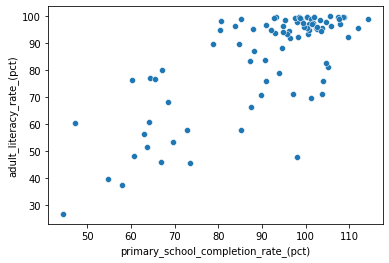

In [4]:
sns.scatterplot(
    data = wbl,
    x = 'primary_school_completion_rate_(pct)',
    y = 'adult_literacy_rate_(pct)'
)

It looks like there is some connection here! As primary school completion rate increases, so does the literacy rate. We might call this a **positive trend**. Plus, it looks like you might be able to draw a line through the middle of this cloud of points to describe the way the cluster of points moves. We might say also that it is a **linear trend**. We can describe this relationship in more depth using the tools of linear regression.

Note that just because these two variables seem to have some pattern when plotted together, that doesn't mean that primary school completion rate *causes* the change in literacy rate. We'll use the word **association** to describe any patter or connection between two variables, because "correlation is not causation".

## Simple linear regression

Simple linear regression is the method we have of modeling the linear association between two variables. You may have learned in algebra that one common way to write the equation of a line is through *slope-intercept form* $b + mx$, where $b$ indicates that the line passes through the point $(0,b)$, called the intercept of the line, and $m$ is the slope. However, these points don't exactly fit a line, but seem to have some random deviations around a general trend line. We can write this *line-plus-random-error* idea using the mathematical equation

\begin{equation}
Y = \alpha + \beta x + \varepsilon.
\end{equation}

This is another type of statistical model, called a linear regression model. It says that the value of (the random variable) $Y$ is just the value along the line $\alpha + \beta x$ plus a random error $\varepsilon$. If we knew the slope $\beta$ and intercept $\alpha$ of the line, then we could plug in the value of $x$ to get a good guess for $Y$, though off by some error.

You probably have many questions at this point, especially if this idea is new to you! But we want to first consider a big one: how do we figure out the equation for the line? There are multiple lines we could draw. Here are three of them!

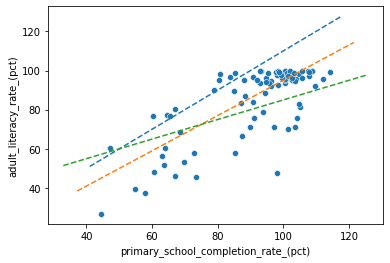

In [5]:
# Make your own line by changing around these numbers:
slope = 1.0
intercept = 10.0
# add scatter plot of data
sns.scatterplot(
    data = wbl,
    x = 'primary_school_completion_rate_(pct)',
    y = 'adult_literacy_rate_(pct)'
)

# plot the line with given slope and intercept
# use function defined in first cell
plot_abline(slope, intercept)
plot_abline(.9, 5.0)
plot_abline(.5, 35)


But which one is best? And what would make a line the "best" one in this situation? The method of least squares, described below, is a way to answer both of these questions.

### Minimizing the Sum of Squares Error

If you spent some time thinking about where the "best" line should go, you probably tried to get it somewhere in the middle of the cloud of points, so that it wasn't too far away from any one point. In that way it would follow the general trend, even if it didn't exaclty match any of the data points. 

We can make this idea more mathematical by considering something called the **residual**. Given any line $\hat y = a + bx$, the residual is the difference between the actual value of $y$ associated with $x$, and the value $\hat y$ that lies along the line, i.e., the residual is $y - \hat y$.

Below we look at plots of two different lines, and examine the residuals associated with a few points in our "cloud" of data points. The residual for each point is the vertical distance from the point to the line. Which line do you think better fits the trend of the points? And what is the difference between the the residuals of the two trend lines?

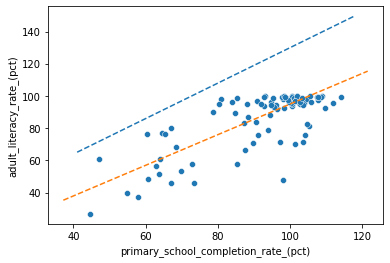

In [6]:
sns.scatterplot(
    data = wbl,
    x = 'primary_school_completion_rate_(pct)',
    y = 'adult_literacy_rate_(pct)'
)

# plot the line with given slope and intercept
# use function defined in first cell
plot_abline(1.1, 20)
plot_abline(.95, 0)

# add in lines showing the residuals

The better trend line has overall smaller residuals, so we might think that it would help  to pick the line that minimizes the sum of the residuals.

However, the worse line has only negative residuals! So in fact the sum of the residuals is a negative number that will be smaller. It turns out we don't care about the sign of the residual, only it's magnitude! To solve this issue, we square each of the residuals and take the sum to form a **sum of squared errors (SSE)**

\begin{equation}
    SSE = \sum_{i=1}^n (y_i - \hat y_i)^2
\end{equation}

In the end, we want to find the slope and intercept of the line that minimizes this quantity. Since we are minimizing the sum of squared errors, this best-fit line also goes by the name **least-squares regression** line. Solving this problem looks like it could be tricky, but it turns out that the solution is straightforward when we employ the help of a little bit of calculus. Or, even nicer (in the author's opinion) is to use a little algebra **(link to algebra chapter)**. We do need to assume that the random error $\varepsilon$ is normally distributed, but we will gloss over this for now. You can read more about how to find the line of best fit elsewhere if you're interested, but here we'll simply find the solution using code.

Why square the residuals and not just take the absolute value? One reason is mathematical: there is always a unique global minimizer to the SSE. Since squaring a large number will make it larger, this method penalizes very large residuals. Another reason is statistical: it turns out the slope and intercept of the least squares solution have special mathematical properties which make them the *maximum likelihood estimators* of the model's true slope and intercept. But we won't look into that here!

### Finding the Least Squares Line

First, we can easily get a plot of the regression line using `seaborn`'s `lmplot`:

/home/timothyproject/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



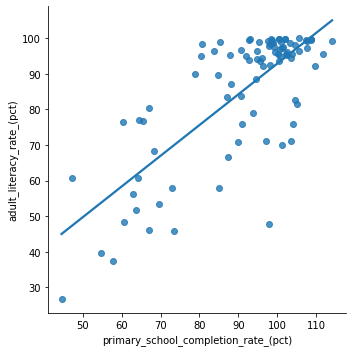

In [7]:
sns.lmplot(
    data = wbl,
    x = 'primary_school_completion_rate_(pct)',
    y = 'adult_literacy_rate_(pct)',
    ci = None
);

But what if we want to be more precise and want the equation of the line? For this, we'll use some functionality from the `OLS` module in `statsmodels`. This is going to display a lot of stuff, but we'll walk through it slowly!

In [8]:
x = 'primary_school_completion_rate_(pct)'
y = 'adult_literacy_rate_(pct)'
model = sm.regression.linear_model.OLS(
    wbl[y], # the dependent variable (y)
    sm.tools.tools.add_constant(wbl[x]) # the independent variable (x)
)
results = model.fit()
print(results.summary())

                                OLS Regression Results                               
Dep. Variable:     adult_literacy_rate_(pct)   R-squared:                       0.567
Model:                                   OLS   Adj. R-squared:                  0.562
Method:                        Least Squares   F-statistic:                     114.0
Date:                       Tue, 11 Jul 2023   Prob (F-statistic):           1.70e-17
Time:                               15:59:19   Log-Likelihood:                -346.82
No. Observations:                         89   AIC:                             697.6
Df Residuals:                             87   BIC:                             702.6
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

Wow! There is a lot of information here, most of which we'll explain later on. For now, let's see how to get the information about the slope and the intercept of the line. You can find these values in the second table under the column heading "coef". From this, we can see that the intercept (`const`) is 6.6714, and the slope associated with the primary school completion rate is 0.8615. We can write that as the line

\begin{equation}
    \hat y = 6.6714 + 0.8615 x
\end{equation}

Now that we have this line, how can we understand how to use it? First, the slope tells us how the changes in $x$ are connected to changes in $\hat y$. Here, an increase of 1% in the primary school completion rate ($x$) is associated with an average increase of about .865% in the literacy rate ($y$). 

The intercept is a bit harder to interpret in this context, but it's saying that in this model, a country with 0% primary school completion rate will, on average, have a literacy rate of 6.6714%. Of course, a 0% completion rate is much outside the range of values we have for $x$, and we don't recommend using the model to make predictions there! 

Next, we want to look at how well this model fits the data.

### $R^2$ and Goodness of Fit tests

We mentioned before that that we are using linear regression to *model* the relationship between two variables. But this only works if these variables actually have a linear relationship! Maybe they are actually related in a nonlinear way, or not related at all.

We can get some idea of this by looking at the scatter plot, but we can also quantify the strength of a linear relationship through a number called the **correlation coefficient** $r$. The number $r$ is a value between $-1$ and $1$ that gives measures the strength of the linear association between two variables.

What's a large value of $r$ versus a small one? It depends on the problem! And as you get more comfortable with this, you'll get a sense for it. Below we'll take a closer look at how to understand this. As you look at these different plots, which would you say have a strong linear association?

In [9]:
# TO DO: interactive plot of different r's
# or just a plot with several different choices of r

There are a few ways to calculate $r$ in Python. First, we could calculate it directly using the `pearsonr` command from `scipy.stats`:

In [10]:
x = wbl['primary_school_completion_rate_(pct)']
y = wbl['adult_literacy_rate_(pct)']
r = scipy.stats.pearsonr(x, y)[0]

r

0.7531156213152442

Second, we also get the magnitude of $r$ in the output of our linear model. If you look above, you see that the output of the linear model says `R-squared: 0.567`. This actually provides you with a value $r^2$, which is simply the square of the correlation coeffient $r$ that we calculated above:

In [11]:
r**2

0.5671831390690464

Even though it doesn't tell us if the trend is positive or negative, $r^2$ is often preffered to $r$ as it has a simple interpretation. The value of $r^2$ quantifies the percentage of variation in $Y$ that is explained by the linear model.

In the context of our problem, using a linear model with the primary school completion rate explains 56.7% of the variation in literacy rates between the countries. More simply, the school completion rate explains some of the differences in literacy rates between countries, but not all, and that amount is quantified as 56.7%.

Is this a small or large amount? One way to quantify how well the model fits is through a *Goodness of Fit Test*. Without giving all of the details, this is a hypothesis test that determines if the value of $r$ is significantly different from 0. In terms of hypotheses, the null hypothesis is that the model is not a good fit, versus the alternative that it is a good fit.

The test statistic has a special type of distribution called an F distribution, and its value can be found one the right of the summary table as `F-statistic`. The $P$-value for the test is right below it. In this case an F statistic of 114.0 yields a $P$-value of $1.70\times 10^{-17}$, which is about as close to 0 as you can get on a standard computer. Hence, we reject the null hypothesis, and conclude that this linear model fits the data well.

There is a lot more to these kinds of tests, which become more important in the multiple regression case. We'll come back to that later on!

## Inference on model parameters

Now that we know how to find the line of best fit, we want to know how good our estimates of the slope and intercept are. We began by assuming that there was a linear model describing the relationship between $x$ and $Y$:

\begin{equation}
Y = \alpha + \beta x + \varepsilon.
\end{equation}

Because we only have limited data on the relationship between these two variables $x$ and $Y$, we can't calculate $\alpha$ and $\beta$ exactly, but only estimate them with our least squares estimates $a$ and $b$. How can we know how good these estimates actually are? We again turn to our statistical inference tools of the confidence interval and hypothesis test.

### A test of hypothesis for $\beta = 0$.

A big question in linear regression is whether knowing the value of $x$ makes a difference in our estimation of $Y$. If it didn't, the slope value in the model would actually be 0. If it does, it would be something different from 0. But $\beta$ is a parameter of the model, which we estimated by calculating $b$. We can use our hypothesis testing skills to decide if $\beta = 0$ or not!

\begin{equation}
    H_0: \beta = 0, \\ H_1: \beta \neq 0.
\end{equation}

We can show that the test statistic for this hypothesis test is a T random variable, and the value is given in the model summary readout. Look for the column `t`, just two columns to the right of where you found the coefficients. And just next to that is the $P$-value for the test.

In this case, we go $T=10.677$ which yields a $P$-value of 0.000. This woulc cause us to reject the null hypothesis, and conclude that the true slope is actually different from 0. We can also give a 95% confidence interval for our estimate of the slope, which is again given in the table as $(0.701, 1.022)$.

If this seems similar to the goodness of fit test we just covered, you're right! In fact, they are exactly the same in the simple linear regression case (verify for yourself that $F = T^2$). However, once we move to the multiple regression case, they will no longer be the same, and both tests will be important!

Before moving on, make sure you take some time to look over the model summary output again, and that you can find all the information we talked about in the text.

## Model diagnostics

To wrap up our discussion of simple linear regression, we need to address a few details that we have so far glossed over. In all of the previous discussion, we have made a few assumptions at which we need to take a deeper look.

We assumed:

1. $Y$ and $x$ really do have a linear relationship. We made this assumption when we decided to use the model $Y = \alpha + \beta x + \varepsilon$.
2. The random error $\varepsilon$ is normally distributed with mean 0.
3. The random error $\varepsilon$ is independent of $x$. 

These last two assumptions were not explicitly stated, but are needed to make the regression interpretations work. And when we make assumptions like this, we need to check to see if these are reasonable! Here, we will show how to visually evaluate these assumptions using graphs.

The first question of the relationship between $Y$ and $x$ can be easily evaluated through the scatter plot we made at the beginning of the section. If the scatter plot isn't clear, then the correlation coefficient can help!

We can evaluate the next two claims by examining the residuals. The residuals are related to the random error since according to the model,

\begin{equation}
    y_i - \hat y_i =  y_i - (a + b x_i) \approx y_i - (\alpha + \beta x_i) = \varepsilon_i.
\end{equation}

Plotting the residuals will give us an idea about the distribution of the $\varepsilon$, but we need two different types of plots to examine the assumptions.

First, we can plot a histogram of the residuals

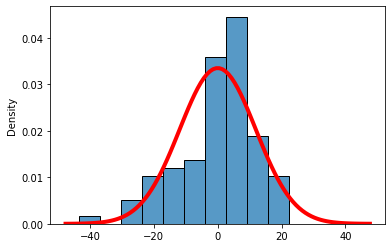

In [12]:
sns.histplot(
    x = results.resid,
    stat = 'density'
)
std = np.std(results.resid)
x = np.linspace(-std*4, std*4, 100)
plt.plot(
    x,
    scipy.stats.norm.pdf(x, loc=np.mean(results.resid), scale=std),
    color = 'red',
    linewidth = 4,
);

Here we see that the residuals have a roughly mound shaped distribution though there is some left skew and the histogram deviates somewhat from the normal distribution. We will say that the normal residual assumption is ok in this case, but it doesn't look as normal as we might like!

Finally, we look at a scatter plot between $x$ and the residuals. If the errors are truly independent of $x$, then we will not observe any patterns in the graph, and it should look like a random cloud of points. There should be roughly an equal number spread out above and below 0, with most of them being close to 0.

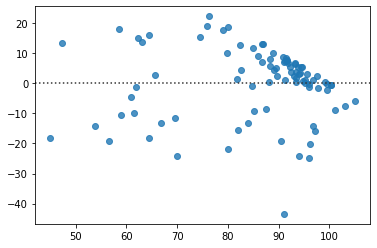

In [13]:
sns.residplot(
    x = results.fittedvalues,
    y = results.resid,
);

What would it look like if there was a pattern? Here is an example using a different variable from our data along the $x$-axis.

                                OLS Regression Results                               
Dep. Variable:     adult_literacy_rate_(pct)   R-squared:                       0.000
Model:                                   OLS   Adj. R-squared:                 -0.011
Method:                        Least Squares   F-statistic:                  0.003546
Date:                       Tue, 11 Jul 2023   Prob (F-statistic):              0.953
Time:                               15:59:20   Log-Likelihood:                -384.08
No. Observations:                         89   AIC:                             772.2
Df Residuals:                             87   BIC:                             777.1
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

/home/timothyproject/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



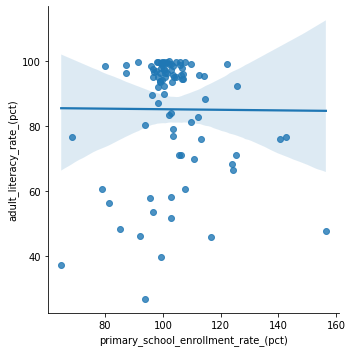

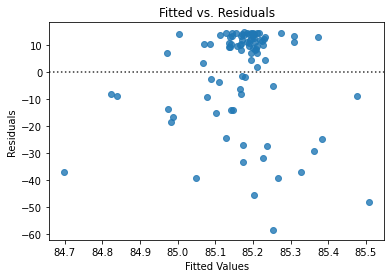

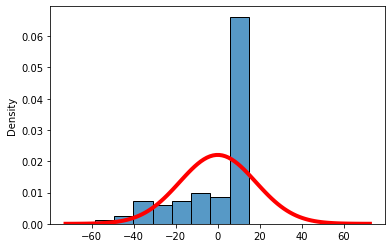

In [14]:
x = 'primary_school_enrollment_rate_(pct)'
y = 'adult_literacy_rate_(pct)'
model = sm.regression.linear_model.OLS(wbl[y], sm.tools.tools.add_constant(wbl[x]))
results = model.fit()
print(results.summary())

sns.lmplot(
    data = wbl,
    x = x,
    y = y,
)

fig, ax = plt.subplots()
sns.residplot(
    x = results.fittedvalues,
    y = results.resid,
    ax = ax,
)
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title("Fitted vs. Residuals")

fig, ax = plt.subplots()
sns.histplot(
    x = results.resid,
    stat = 'density'
)
std = np.std(results.resid)
x = np.linspace(-std*4, std*4, 100)
ax.plot(
    x,
    scipy.stats.norm.pdf(x, loc=np.mean(results.resid), scale=std),
    color = 'red',
    linewidth = 4,
);

If all of these plots look ok, then the assumptions are reasonable, and our modeling results can be trusted! If not, you may have to proceed with another method, but this is outside the scope of this section!

## Exercises

What sorts of team statistics are associated with winning in the English Premier League? We can explore this question at a high level using simple linear regression.

Below we load a data set that contains the league standings, along with some common statistics, for the 2022-23 EPL season. A few notes:

- `points` is the total number of points accrued by a team through winning or drawing matches. A team earns 1 point for a draw, and 3 points for a win.
- `goals_for` is the number of goals scored by the team, while `goals_against` is the number of goals allowed by the team. `goal_diff` is how many more (or less) goals a team scored than allowed.

In [15]:
epl = pd.read_csv('epl_table_22_23.csv')
epl.head()

,team,wins,draws,losses,points,goals_for,goals_against,goal_diff,expected_goals_for,expected_goals_against,expected_goal_diff,attendance
0,Arsenal,26,6,6,84,88,43,45,71.9,42.0,29.9,60191
1,Aston Villa,18,7,13,61,51,46,5,50.2,52.5,-2.2,39485
2,Bournemouth,11,6,21,39,37,71,-34,38.6,63.9,-25.3,10362
3,Brentford,15,14,9,59,58,46,12,56.8,49.9,6.8,17078
4,Brighton,18,8,12,62,72,53,19,73.3,50.2,23.1,31477


1. Make a scatter plot of the number of goals a team scored (`goals_for`) versus the number of points they accrued in the standings (`points`). How would you describe the relationship?
2. Fit a linear model to these two variables, and print out the summary.
3. Use the summary to write down the estimated slope and intercept of the model. Interpret these values in the context of the problem. How many points, on average, is each additional goal scored in the standings?
4. What is the value of $r^2$? Does the model seem to be a good fit? Explain your reasoning.
5. Repeat this analysis with another variable or variables. Do your new models seem to be a better or worse fit? Why or why not?
6. Do you think `attendance` has any effect on a team's performance? Use some of the tools from this section to answer, and explain what you find. How might you use this example to help understand the common phrase "correlation is not causation"?

## Multiple regression

**Everything else here is under construction**

We might also be interested in the case when there are many independent variables that are connected to an output. ** To do ** 

### Dummy Variables

Categorical or qualitative variables can also sometimes be incorporated into a linear regression model by an appropriate transformation.

### Model Diagnostics

The assumptions for a multiple linear regression model are the same as for a simple linear regression model, but may be slightly more difficult to evaluate.

### Inference on Model Parameters

The techniques of inference that we talked about in the single variable case carry over to the multiple regression model. The main difference is the interpretation of the readout results. Because we have multiple variables involved in the model, which themselves may be linearly connected, complicates things somewhat.

## Exercises